# Computing leaf tortuosity from segmented leaf microCT stacks
## Using the method in Earles et al. (to be submitted)

__Created__ on 2018-03-21 by Guillaume Théroux-Rancourt (guillaume.theroux-rancourt@boku.ac.at)

__Last edited__ on 2018-03-21 by Guillaume Théroux-Rancourt

To compute the geodesic distance, you need to install [the geodesic functions here](https://github.com/taigw/geodesic_distance).

In [17]:
import skimage.io as io
from skimage import img_as_int, img_as_ubyte, img_as_float, feature, measure, color, morphology, filters
import numpy as np
from scipy import ndimage
from scipy.ndimage.morphology import distance_transform_edt
import geodesic_distance as gd
import random
import cv2
import matplotlib.pyplot as plt
from skimage.util import invert
import skfmm

In [3]:
# Create convenience functions

def Threshold(input_img, Th_value):
    tmp = np.zeros(input_img.shape, dtype=np.float32)
    if isinstance(Th_value, int):
        tmp[input_img == Th_value] = 1
    else:
        if isinstance(Th_value, float):
            tmp[input_img > 0. & input_img < 1.] = 1
        else:
            for i in range(len(Th_value)):
                tmp[input_img == Th_value[i]] = 1
    return tmp 

def DisplayRndSlices(input_img, nb_of_slices):
    for i in random.sample(range(input_img.shape[0]), nb_of_slices):
        io.imshow(input_img[i,:,:])
        io.show()

# EdgeDetector3D detects the edge and is not equivalent to ImageJ's Binary > Outline if used on the airspace stack
# There's a Gaussian filter beging applied (sigma=). Using a low value doesn't necessarily close the edges.
# So, a better function should be implkemented
# Speed is ok but there is room for improvement
# see here for potential solution: https://stackoverflow.com/questions/29434533/edge-detection-for-image-stored-in-matrix
def EdgeDetector3D(input_img):
    tmp = np.zeros(input_img.shape)  
    for i in range(input_img.shape[0]):
        tmp[i,:,:] = feature.canny(input_img[i,:,:], sigma=0.33)
    return tmp

# Better solution I found so far, but the edge is 2 pixel wide, i.e. going over both the airspace and non-airspace
# from https://stackoverflow.com/questions/29434533/edge-detection-for-image-stored-in-matrix
# Assumes you have a binary image
# TO DO:
# - Find a way to have only one pixel wide
# - Get rid of creating a color image
# - Get it into a 8-bit. It seems to be stuck to int64
def Outline2D(input_img):
    img_raw = input_img
    img_zero = np.zeros_like(img_raw, dtype=np.uint8)
    img = np.zeros_like(img_raw, dtype=np.uint8)
    img[:,:] = 128
    img[ img_raw < 0.25 ] = 0
    img[ img_raw > 0.75 ] = 255
    # define "next to" - this may be a square, diamond, etc
    selem = morphology.square(2)
    # create masks for the two kinds of edges
    black_white_edges = (filters.rank.minimum(img, selem) == 0) & (filters.rank.maximum(img, selem) == 255)
    # create a color image
    img_result = np.dstack( [img_zero,img_zero,img_zero] )    
    # assign colors to edge masks
    img_result[ black_white_edges, : ] = np.asarray( [ 0, 255, 0 ] )
    img_result = color.rgb2gray(img_result) * 255
    img_result = img_result.astype(np.uint8)    
    return img_result

def Outline3D(input_img):
    tmp = np.zeros(input_img.shape)  
    for i in range(input_img.shape[0]):
        tmp[i,:,:] = Outline2D(input_img[i,:,:])
    return tmp
    

### Image Loading and Pre-processing

In [4]:
# Set path to tiff stacks
filepath = '/Volumes/HD_1/LeafAir-WorkDir/_Ferns/Dennstaedtia-cicutaria/'

(400, 120, 924)
[  0  85 152 170 255]


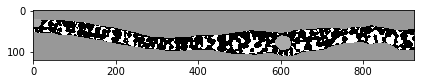

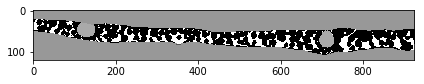

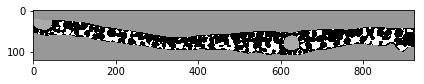

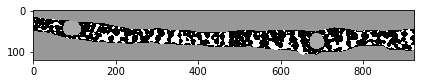

In [5]:
# Read composite stack including slabelling of stomata
composite_stack = io.imread(filepath + 'Dennstaedtia-cicutaria-COMPOSITE-topLeaf-cropped-w-stomata.tif')
# outline_stack = io.read(filepath + )
print(composite_stack.shape)
print(np.unique(composite_stack)) # to get all the unique values

# show a few slices
for i in random.sample(range(composite_stack.shape[0]), 4):
    io.imshow(composite_stack[i,:,:])
    io.show()


[0 1]
float32
uint8


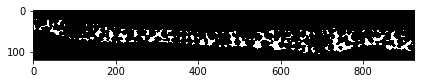

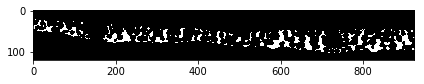

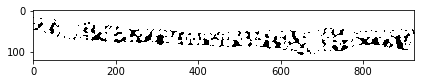

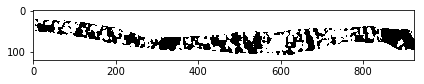

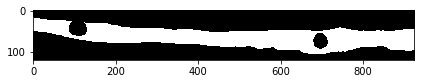

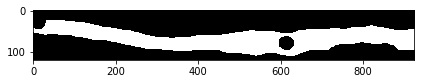

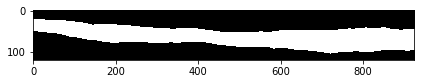

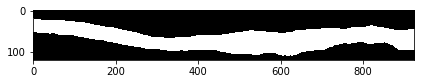

In [6]:
# Create the binary stacks needed for the analysis
mesophyll_wo_veins_stack = np.asarray(Threshold(composite_stack, [0,255]), np.float32)
mesophyll_stack = np.asarray(Threshold(composite_stack, [0,170,255]), np.float32)
cell_stack = np.asarray(Threshold(composite_stack, [0,170,152]), np.float32)
airspace_stack = np.asarray(Threshold(composite_stack, 255), np.float32)
stomata_stack = np.asarray(Threshold(composite_stack, 85), np.uint8)
print(np.unique(stomata_stack))
print(airspace_stack.dtype)
print(stomata_stack.dtype)

DisplayRndSlices(airspace_stack, 2)
DisplayRndSlices(cell_stack, 2)
DisplayRndSlices(mesophyll_wo_veins_stack, 2)
DisplayRndSlices(mesophyll_stack, 2)

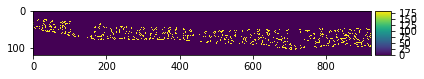

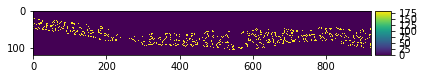

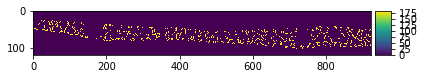

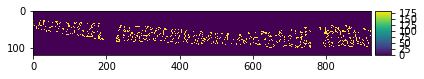

In [23]:
# Detect edges of airspace

airspace_outline = Outline3D(airspace_stack)

DisplayRndSlices(airspace_outline, 4)

# cell_outline = EdgeDetector3D(cell_stack)
# airspace_outline = EdgeDetector3D(airspace_stack)
# epidermis_edge = EdgeDetector3D(mesophyll_stack)
# airspace_outline = Outline3D(airspace_stack)
# DisplayRndSlices(airspace_outline, 5)
# DisplayRndSlices(epidermis_edge, 5)
# io.imsave(filepath + '_airspace-outline.tif', img_as_ubyte(airspace_outline))
# io.imsave(filepath + '_cell-outline.tif', img_as_ubyte(cell_outline))
# io.imsave(filepath + 'epidermis-outline.tif', img_as_ubyte(epidermis_edge))

In [ ]:
# Get the distance maps

mask = np.ma.MaskedArray(airspace_stack)

In [ ]:
#toto = distance_transform_edt(invert(stomata_stack))
toto = skfmm.distance(invert(airspace_outline))
# L_geo = gd.geodesic3d_fast_marching(airspace_stack,stomata_stack)
# #L_geo = gd.geodesic3d_raster_scan(airspace_stack,stomata_stack,1,4)

DisplayRndSlices(toto, 2)

In [15]:
print(toto)

[[[  1.00000000e+00   1.41421356e+00   2.23606798e+00 ...,   9.21000543e+02
     9.22000542e+02   9.23000542e+02]
  [  1.41421356e+00   1.73205081e+00   2.44948974e+00 ...,   9.21001086e+02
     9.22001085e+02   9.23001083e+02]
  [  2.23606798e+00   2.44948974e+00   3.00000000e+00 ...,   9.21002714e+02
     9.22002711e+02   9.23002709e+02]
  ..., 
  [  1.17004273e+02   1.17008547e+02   1.17021366e+02 ...,   9.28402391e+02
     9.29394426e+02   9.30386479e+02]
  [  1.18004237e+02   1.18008474e+02   1.18021185e+02 ...,   9.28528944e+02
     9.29520844e+02   9.30512762e+02]
  [  1.19004202e+02   1.19008403e+02   1.19021007e+02 ...,   9.28656557e+02
     9.29648321e+02   9.30640102e+02]]

 [[  2.00000000e+00   2.23606798e+00   2.82842712e+00 ...,   9.21002172e+02
     9.22002169e+02   9.23002167e+02]
  [  2.23606798e+00   2.44948974e+00   3.00000000e+00 ...,   9.21002714e+02
     9.22002711e+02   9.23002709e+02]
  [  2.82842712e+00   3.00000000e+00   3.46410162e+00 ...,   9.21004343e+02
  

# Works up to this point

[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]


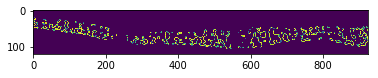

In [65]:
input_img = airspace_stack[0,:,:]
sx = ndimage.sobel(input_img, axis=0, mode='constant')
sy = ndimage.sobel(input_img, axis=1, mode='constant')
sob = np.hypot(sx, sy)
print(sob)
plt.imshow(sob)
plt.show()
plt.imsave(filepath + '_airspace-outline-test.tif', sob)

In [75]:
import scipy as sp
from pprint import pprint
#Load image
im = input_img

n, bins_edges = np.histogram(im.flatten(),bins = 100)
# Skip the black area, and assume two distinct regions, white and grey
max_counts = np.sort(n[bins_edges[0:-1] > 0])[-2:]
thresholds = np.select(
    [max_counts[i] == n for i in range(max_counts.shape[0])],
    [bins_edges[0:-1]] * max_counts.shape[0]
)
# filter our the non zero values
thresholds = thresholds[thresholds > 0] 


fig, axs = plt.subplots()
# Display image
axs.imshow(im, interpolation='nearest', cmap=plt.cm.gray)
colors = ['r','g']


In [79]:
thresholds

array([ 0.01,  0.02,  0.03,  0.04,  0.05,  0.06,  0.07,  0.08,  0.09,
        0.1 ,  0.11,  0.12,  0.13,  0.14,  0.15,  0.16,  0.17,  0.18,
        0.19,  0.2 ,  0.21,  0.22,  0.23,  0.24,  0.25,  0.26,  0.27,
        0.28,  0.29,  0.3 ,  0.31,  0.32,  0.33,  0.34,  0.35,  0.36,
        0.37,  0.38,  0.39,  0.4 ,  0.41,  0.42,  0.43,  0.44,  0.45,
        0.46,  0.47,  0.48,  0.49,  0.5 ,  0.51,  0.52,  0.53,  0.54,
        0.55,  0.56,  0.57,  0.58,  0.59,  0.6 ,  0.61,  0.62,  0.63,
        0.64,  0.65,  0.66,  0.67,  0.68,  0.69,  0.7 ,  0.71,  0.72,
        0.73,  0.74,  0.75,  0.76,  0.77,  0.78,  0.79,  0.8 ,  0.81,
        0.82,  0.83,  0.84,  0.85,  0.86,  0.87,  0.88,  0.89,  0.9 ,
        0.91,  0.92,  0.93,  0.94,  0.95,  0.96,  0.97,  0.98,  0.99])

In [96]:
for i, threshold in enumerate(thresholds):
    contours = measure.find_contours(im, threshold)


In [84]:
for i, threshold in enumerate(thresholds):
    contours = measure.find_contours(im, threshold)
    # Display  all contours found for this threshold
    for n, contour in enumerate(contours):
        axs.plot(contour[:,1], contour[:,0], lw = 4)

axs.axis('image')
axs.set_xticks([])
axs.set_yticks([])        
plt.show()

KeyboardInterrupt: 